In [ ]:
%pylab inline 

import numpy as np


# Introduction

Machine learning 그리고 deep learning은 단순히 연구에서 머물지 않고, 실제 서비스 그리고 엔터프라이즈 환경에서 사용이 되고 있습니다.<br>
하나의 모델을 만들고 튜닝하는데에는 ML engineer의 고도화된 튜닝 기법들이 필요합니다.<br>
문제는 튜닝을 하는데 많은 시간이 소요가 되며, 이것은 낮은 생산성으로 이어지게 됩니다. <br>
특히 딥러닝의 경우 정말 많은 hyperparameters 가 존재합니다. <br>
모델의 아키텍쳐, learning rate, epsilon value, drop rate 등등 종속변수에 영향을 미치는 변수들이 상당히 많습니다. <br>
현실적인 관점에서 기존 ML은 그나마 좀 빠르게 학습되는데 반해서, 딥러닝 모델의 경우 모델에 따라서 몇일이 걸리는 일도 발생합니다. 

Auto ML은 다음의 3가지의 문제를 해결하는데 도움을 줍니다. 

1. **Time Saving**: Auto ML은 data extraction 그리고 algorithm tuning을 자동으로 하면서, 수작업으로 하던 일들을 크게 줄여줍니다.
2. **Improved Accuracy**: 실제 업무를 하다보면, 모델이 나오는 것까지는 하지만 튜닝에 들어가는 시간이 없어서 대충 기본값만 사용하는 케이스가 꽤 많습니다. 이러한 일들이 자동으로 되면서 휴먼 에러를 줄이고, 일정상 못하던 튜닝이 자동으로 되면서 매우 높은 accuracy로 향상 시킬수 있습니다.


# Data 

## Regression Data

먼저 예제로 사용할 regression data를 정의합니다. <br>
예제에서는 diabetes 데이터를 활용합니다.

In [138]:
def regression_data():
    np.random.seed(2685)
    x_data, y_data = load_diabetes(True)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,)
    columns = load_diabetes()['feature_names']
    
    return x_train, y_train, x_test, y_test, columns

def visualize_regression(y_true, y_pred):
    fig, plots = subplots(1, 2, figsize=(16, 6))
    plots = plots.reshape(-1)
    
    sort_idx = np.argsort(y_true)
    y_sorted_true = y_true[sort_idx]
    y_sorted_pred = y_pred[sort_idx]
    
    sns.scatterplot(np.arange(len(y_pred)), y_pred, label='blue', ax=plots[0])
    sns.scatterplot(np.arange(len(y_pred)), y_true, color='red', label='true', ax=plots[0])
    sns.scatterplot(np.arange(len(y_pred)), y_sorted_pred, label='blue', ax=plots[1])
    sns.scatterplot(np.arange(len(y_pred)), y_sorted_true, color='red', label='true', ax=plots[1])
    plots[0].set_title('unsorted predictions')
    plots[1].set_title('sorted predictions')
    print('RMSE:', mean_squared_error(y_test, y_pred) ** 0.5)
    print('R^2 :', r2_score(y_test, y_pred) ** 0.5)

# Manual Models

Auto ML을 사용안했을때와 비교하기 위해서 제가 손 튜닝한 모델의 performance를 기록합니다.


## Decision Tree

RMSE: 72.95889253545451
R^2 : 0.25863112218664946


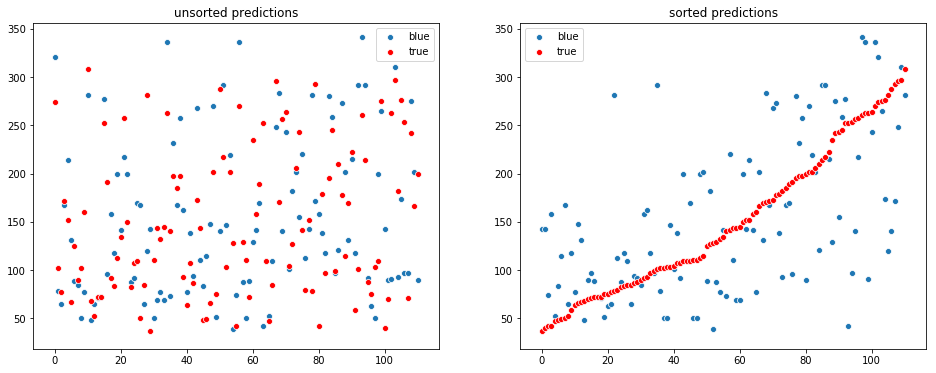

In [139]:
from sklearn.tree import DecisionTreeRegressor
x_train, y_train, x_test, y_test, columns = regression_data()

dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)

# Evaluation
y_pred = dt.predict(x_test)

visualize_regression(y_test, y_pred)

## LightGBM

Best Iteration: 33
RMSE: 52.06965531596246
R^2 : 0.7243784507478606


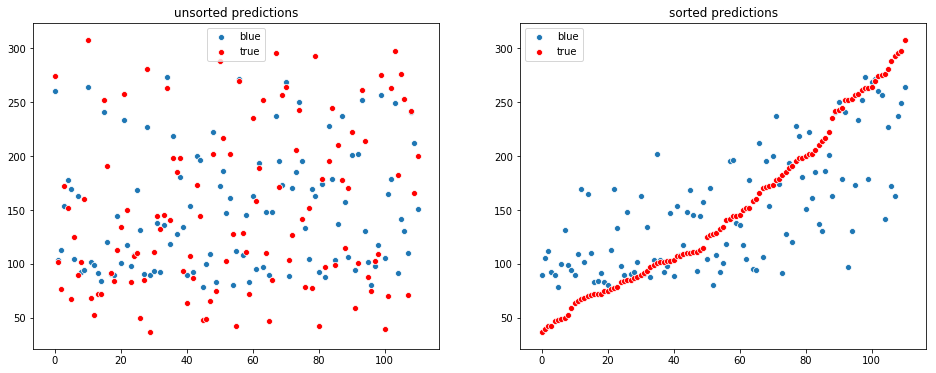

In [140]:
# Data
x_train, y_train, x_test, y_test, columns = regression_data()

# LightGBM Regression Model
gbm = lgb.LGBMRegressor(mc='0,0,0,0,0,0,0,0,0,0', 
                        learning_rate=0.07, 
                        n_estimators=64, 
                        seed=0)
gbm.fit(x_train, y_train, eval_metric='l2', 
        eval_set=[(x_test, y_test)],
        early_stopping_rounds=5, verbose=False)

# Evaluation
print('Best Iteration:', gbm.best_iteration_)
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

visualize_regression(y_test, y_pred)

## Deep Learning

RMSE: 57.681172235182764
R^2 : 0.6455724229579262


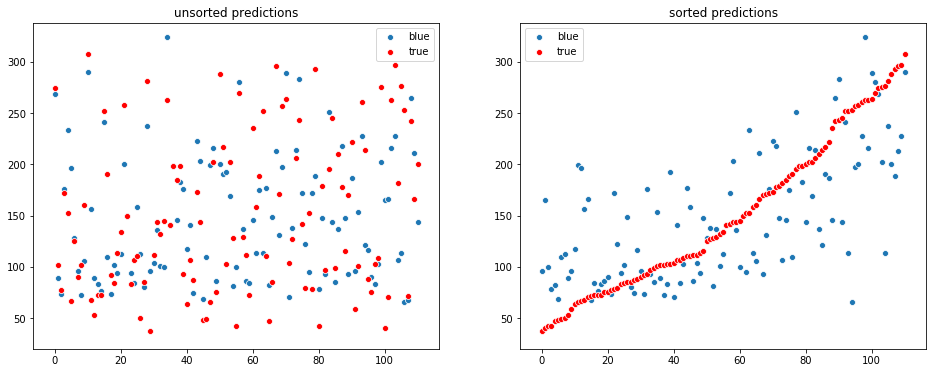

In [141]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
set_random_seed(0)

# Data
x_train, y_train, x_test, y_test, columns = regression_data()

# Scaling
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

model = Sequential()
model.add(Dense(128, input_shape=(10,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',  optimizer='adam',)

es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(x_train, y_train, batch_size=32, epochs=64, validation_data=(x_test, y_test), 
          callbacks=[es], verbose=0)

y_pred = model.predict(x_test)
y_pred = y_scaler.inverse_transform(y_pred).reshape(-1)
visualize_regression(y_test, y_pred)



# Auto-Sklearn


## Installation

설치는 다음과 같이 합니다. 

```
sudo pip install auto-sklearn
```


## Seachspace 줄이기
Seachspace를 줄이기 위해서는 다음과 같이 합니다.

```
automl = autosklearn.classification.AutoSklearnClassifier(
    include_estimators=["random_forest", ], exclude_estimators=None,
    include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None)
```

Auto-Sklearn은 data preprocessing 그리고 feature preprocessing 두가지로 나뉩니다. <br>
data preprocessing은 현재 없앨수 없으며, feature preprocessing은 `include_preprocessors=["no_preprocessing"]` 으로 끌수 있습니다.

**Data Preprocessing** : 끌수 없음
 - one hot encoding of categorical features
 - imputation of missing values 
 - normalization of features or samples

**Feature Preprocessing**: 끌수 있음
 - Feature selection 
 - Trasformation of features into a different space (PCA)
 
 

string 부분은 아래 링크의 파일 이름을 적으면 됩니다.

- [Classifiers](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/classification)
- [Regressors](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/regression)
- [Preprocessors](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/feature_preprocessing)


## Regression Example

In [142]:
from autosklearn.regression import AutoSklearnRegressor
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

x_train, y_train, x_test, y_test, columns = regression_data()

automl = AutoSklearnRegressor(time_left_for_this_task=300, 
                              include_preprocessors=["no_preprocessing"],
                              per_run_time_limit=30,
                              n_jobs=32)
automl.fit(x_train, y_train, x_test, y_test)

[WARNING] [2019-12-20 13:58:59,688:AutoMLSMBO(4282876139)::3fe0d00d6db20f82286eea617111a6ed] Could not find meta-data directory /usr/local/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.04958e-05
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[1

[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:00] /workspac

[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:01] /workspac

[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:03] /workspac

[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:04] /workspac

[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspac

[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:12] /workspac

[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspac

[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:13] /workspac

[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:31] /workspac

[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:39] /workspac

[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[13:59:51] /workspac

[13:59:56] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:56] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:56] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:57] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:57] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:58] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[13:59:58] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:09] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:09] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[14:00:12] /workspac

[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspac

[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspac

[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:02] /workspac

[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:03] /workspac

[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:04] /workspac

[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:29] /workspac

[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:41] /workspac

[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:02:44] /workspac

[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:03] /workspac

[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:03:30] /workspac

Process Process-619:
json.decoder.JSONDecodeError: Expecting ':' delimiter: line 1 column 186225 (char 186224)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 1091, in fit
    load_models=load_models,
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/usr/local/lib/python3.6/site-packages/autosklearn/smbo.py", line 513, in r

-1
['/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000002.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000000.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000001.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000004.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000003.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000005.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000006.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000007.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000009.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000008.ensemble', '/tmp/autosklearn_tmp_754_2470/.auto-sklearn/ensembles/4282876139.0000000010.ensemble', '/tmp/autosklearn_tmp_754_24

AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=['no_preprocessing'],
                     initial_configurations_via_metalearning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=3072, n_jobs=32, output_folder=None,
                     per_run_time_limit=30, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task=300, tmp_folder=None)

auto-sklearn results:
  Dataset name: 3fe0d00d6db20f82286eea617111a6ed
  Metric: r2
  Best validation score: 0.540654
  Number of target algorithm runs: 5163
  Number of successful target algorithm runs: 3821
  Number of crashed target algorithm runs: 1233
  Number of target algorithms that exceeded the time limit: 109
  Number of target algorithms that exceeded the memory limit: 0


RMSE: 51.77238077392772
R^2 : 0.7281040518657207


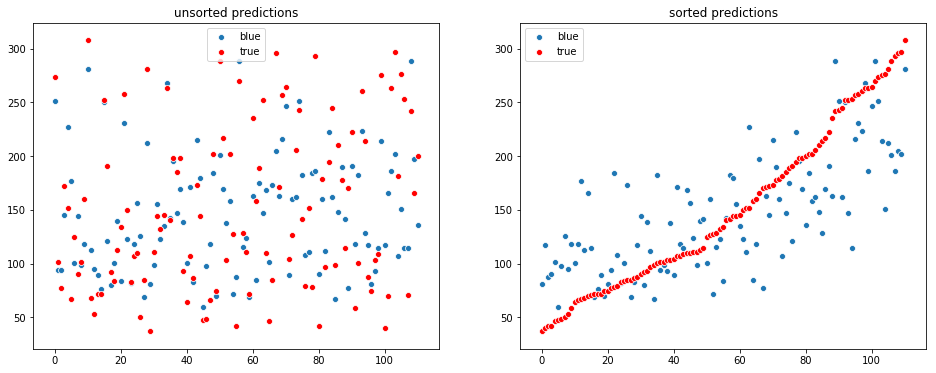

In [143]:
y_pred = automl.predict(x_test)

print(automl.sprint_statistics())
print()
visualize_regression(y_test, y_pred)

RMSE: 51.77238175950974
R^2 : 0.7281040395807585


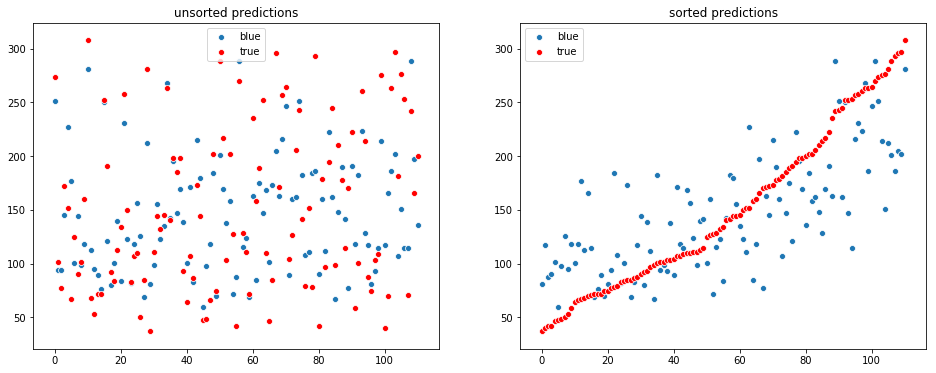

In [144]:
y_preds = []
for weight, model in automl.get_models_with_weights():
    y_pred = model.predict(x_test)
    y_preds.append(y_pred * weight)
    
y_pred = np.sum(y_preds, axis=0)
visualize_regression(y_test, y_pred)


# MLBox

설치는 다음과 같이 합니다. 

```
sudo pip install mlbox
```

### Reading Data

 - train 그리고 test 데이터 구분 방법은 y 컬럼이 있는지 없는지로 구분
 - 반드시 csv 파일로 읽어야 됨

In [145]:
from mlbox.preprocessing import Reader, Drift_thresholder
from mlbox.optimisation import Optimiser
from mlbox.prediction import Predictor
from mlbox.model.regression import Regressor

# Data
x_train, y_train, x_test, y_test, columns = regression_data()
if not os.path.exists('test.csv'):
    pd.DataFrame(np.c_[x_train, y_train], columns=columns + ['y']).to_csv('train.csv')
    pd.DataFrame(x_test, columns=columns).to_csv('test.csv')
    
# Make Reader
paths = ['train.csv', 'test.csv']
rd = Reader(sep=',', to_path='mlbox_save')
rd_data = rd.train_test_split(paths, target_name='y')

# Drift Thresholding
# 자동으로 id 그리고 drifting variables을 삭제 시킵니다. 
rd_data = Drift_thresholder(to_path='mlbox_save').fit_transform(rd_data)


reading csv : train.csv ...
cleaning data ...
CPU time: 9.158944129943848 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 4.1877148151397705 seconds

> Number of common features : 10

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 10
> Number of training samples : 331
> Number of test samples : 111

> You have no missing values on train set...

> Task : regression
count    331.000000
mean     152.719033
std       77.603282
min       25.000000
25%       87.500000
50%      141.000000
75%      214.000000
max      346.000000
Name: y, dtype: float64

computing drifts ...
CPU time: 2.118522882461548 seconds

> Top 10 drifts

('s3', 0.17542809372080992)
('s5', 0.12918394356647367)
('sex', 0.11962525426380854)
('s4', 0.09655719691042819)
('bmi', 0.07487024840803613)
('age', 0.06



### Optimization

optimization을 하기 위해서는 다음과 같이 합니다.

 - **ne**: missing data encoder
 - **ce**: categorical variables
 - **fs**: feature selector
 - **stck**: meta-features stacker
 - **est**: final estimator
 

In [146]:
space = {
    'ne__numerical_strategy': {'space': [0, 'mean', 'median', None]},

    'fs__strategy': {"space": ["variance", "rf_feature_importance", 'l1']},
    'fs__threshold': {"search": "choice", "space": [0.01, 0.05, 0.1, 0.2, 0.3]},

    'est__strategy': {'space': ['LightGBM', ]}, # 'RandomForest', 'AdaBoost', 'Bagging'
    'est__boosting_type': {'search': 'choice', 'space': ['gbdt', 'dart', 'goss', 'rf']},
    'est__num_leaves': {'search': 'choice', 'space': [25, 30, 35, 40]},
    'est__learning_rate': {'search': 'choice', 'space': [0.05, 0.1, 0.2]},
    'est__n_estimator': {'search': 'choice', 'space': [36, 48, 64]}
}

opt = Optimiser()
best = opt.optimise(space, rd_data, max_evals=100)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}       
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.05}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.2, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'nthread': -1, 'seed': 0}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8802.242467250355
VARIANCE : 712.2506209174726 (fold 1 = -9514.493088167826, fold 2 = -8089.991846332881)
CPU time: 0.9463074207305908 seconds                 
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.2, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6793.522714138112                     
VARIANCE : 930.631245516216 (fold 1 = -5862.891468621896, fold 2 = -7724.153959654328)
CPU time: 1.856377363204956 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.2, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample'

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -8802.242467250355                     
VARIANCE : 712.2506209174726 (fold 1 = -9514.493088167826, fold 2 = -8089.991846332881)
CPU time: 1.0049304962158203 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.1, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample':

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8799.872757060506                     
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.9193618297576904 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.2, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample':

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8799.872757060506                     
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.8744819164276123 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.2}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6667.081729608437                     
VARIANCE : 973.6575789372087 (fold 1 = -5693.424150671228, fold 2 = -7640.739308545645)
CPU time: 2.0866434574127197 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample'

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/sklearn/utils/

MEAN SCORE : neg_mean_squared_error = -6923.399977475341                     
VARIANCE : 775.1423297046508 (fold 1 = -6148.25764777069, fold 2 = -7698.542307179991)
CPU time: 2.257838249206543 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.2}             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8788.367780621886                     
VARIANCE : 721.3698144106475 (fold 1 = -9509.737595032533, fold 2 = -8066.997966211238)
CPU time: 0.868211030960083 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.3} 
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsampl

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/sklearn/utils/

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.2, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared_error = -4542.404977944738                      
VARIANCE : 93.92119904990477 (fold 1 = -4448.4837788948325, fold 2 = -4636.3261

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8803.210082033398                      
VARIANCE : 709.5014844581829 (fold 1 = -9512.71156649158, fold 2 = -8093.708597575214)
CPU time: 0.867424488067627 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.1} 
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsampl

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/sklearn/utils/

MEAN SCORE : neg_mean_squared_error = -4121.449136807393                      
VARIANCE : 156.6946658180102 (fold 1 = -3964.754470989383, fold 2 = -4278.143802625404)
CPU time: 0.8614017963409424 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsa

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                       
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8335645198822021 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsa

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.860837459564209 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8388020992279053 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8345465660095215 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8787310123443604 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8685171604156494 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.9136173725128174 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.902989387512207 seconds                                          
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8307585716247559 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8342769145965576 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                      
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.8571209907531738 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                               
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.1, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsamp

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                    
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8437681198120117 seconds                                         
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'sub

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6787.746440003291                       
VARIANCE : 891.434214375186 (fold 1 = -5896.312225628106, fold 2 = -7679.180654378478)
CPU time: 2.0753777027130127 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 's

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.8581435680389404 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8714725971221924 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.1}  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 's

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8802.242467250355                       
VARIANCE : 712.2506209174726 (fold 1 = -9514.493088167826, fold 2 = -8089.991846332881)
CPU time: 0.8534822463989258 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6787.746440003291                       
VARIANCE : 891.434214375186 (fold 1 = -5896.312225628106, fold 2 = -7679.180654378478)
CPU time: 2.090466022491455 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8855075836181641 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.3}  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.8808200359344482 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.3}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



MEAN SCORE : neg_mean_squared_error = -4138.227038543824                       
VARIANCE : 210.67547897727468 (fold 1 = -3927.5515595665497, fold 2 = -4348.902517521099)
CPU time: 0.8847074508666992 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.3}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -4664.622502118744                       
VARIANCE : 206.88966119236602 (fold 1 = -4457.732840926377, fold 2 = -4871.512163311109)
CPU time: 0.8879497051239014 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.2}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occur

MEAN SCORE : neg_mean_squared_error = -4664.622502118744                       
VARIANCE : 206.88966119236602 (fold 1 = -4457.732840926377, fold 2 = -4871.512163311109)
CPU time: 0.8979320526123047 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6787.746440003291                       
VARIANCE : 891.434214375186 (fold 1 = -5896.312225628106, fold 2 = -7679.180654378478)
CPU time: 2.1370105743408203 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.01}              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3858.805442862442                       
VARIANCE : 200.54751419560762 (fold 1 = -3658.2579286668342, fold 2 = -4059.3529570580495)
CPU time: 0.8387541770935059 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -8802.242467250355                       
VARIANCE : 712.2506209174726 (fold 1 = -9514.493088167826, fold 2 = -8089.991846332881)
CPU time: 0.9440052509307861 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.1}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, '

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occur

MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8745889663696289 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.2, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, '

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/sklearn/utils/

MEAN SCORE : neg_mean_squared_error = -3858.805442862442                       
VARIANCE : 200.54751419560762 (fold 1 = -3658.2579286668342, fold 2 = -4059.3529570580495)
CPU time: 0.8864080905914307 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8960440158843994 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.2}  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.2, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, '

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4662.64409861796                        
VARIANCE : 284.93471953851895 (fold 1 = -4377.709379079441, fold 2 = -4947.5788181564785)
CPU time: 0.8691084384918213 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.8970849514007568 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.05}              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, '

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



MEAN SCORE : neg_mean_squared_error = -3858.805442862442                       
VARIANCE : 200.54751419560762 (fold 1 = -3658.2579286668342, fold 2 = -4059.3529570580495)
CPU time: 0.8484194278717041 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.2, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6793.522714138112                       
VARIANCE : 930.631245516216 (fold 1 = -5862.891468621896, fold 2 = -7724.153959654328)
CPU time: 2.074495792388916 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.2}  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4077.193327272383                       
VARIANCE : 180.46883573359673 (fold 1 = -3896.7244915387864, fold 2 = -4257.66216300598)
CPU time: 0.8467552661895752 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8864312171936035 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.9107077121734619 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8562209606170654 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8438770771026611 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 1.0335469245910645 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.899878978729248 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8809201717376709 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8971590995788574 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.8528957366943359 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.88130784034729 seconds                                             
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.2, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4542.404977944738                       
VARIANCE : 93.92119904990477 (fold 1 = -4448.4837788948325, fold 2 = -4636.326176994642)
CPU time: 0.8702728748321533 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6787.746440003291                       
VARIANCE : 891.434214375186 (fold 1 = -5896.312225628106, fold 2 = -7679.180654378478)
CPU time: 2.1695556640625 seconds                                              
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.3}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



MEAN SCORE : neg_mean_squared_error = -4138.227038543824                       
VARIANCE : 210.67547897727468 (fold 1 = -3927.5515595665497, fold 2 = -4348.902517521099)
CPU time: 0.886155366897583 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.05} 
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4107.335337858267                       
VARIANCE : 109.15273792556627 (fold 1 = -3998.1825999327, fold 2 = -4216.488075783833)
CPU time: 0.8994777202606201 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.2, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, '

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -4101.45521207943                        
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 1.010227918624878 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'rf', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'sub

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.8838324546813965 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 's

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.9104936122894287 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.2}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -6679.080250806766                       
VARIANCE : 368.7363626953129 (fold 1 = -6310.343888111453, fold 2 = -7047.816613502079)
CPU time: 2.1138031482696533 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -4077.193327272383                       
VARIANCE : 180.46883573359673 (fold 1 = -3896.7244915387864, fold 2 = -4257.66216300598)
CPU time: 0.8920819759368896 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.2, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "

/usr/local/lib/python3.6/site-packages/mlbox/model/re

MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.889930009841919 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -3853.6406541245524                      
VARIANCE : 156.14574251182967 (fold 1 = -3697.4949116127227, fold 2 = -4009.786396636382)
CPU time: 0.83896803855896 seconds                                             
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.3}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



MEAN SCORE : neg_mean_squared_error = -6416.123466851254                       
VARIANCE : 460.1119230474351 (fold 1 = -5956.011543803819, fold 2 = -6876.235389898689)
CPU time: 2.0947301387786865 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.1}  
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 30, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 's

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4107.335337858267                       
VARIANCE : 109.15273792556627 (fold 1 = -3998.1825999327, fold 2 = -4216.488075783833)
CPU time: 0.8677606582641602 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -4542.404977944738                       
VARIANCE : 93.92119904990477 (fold 1 = -4448.4837788948325, fold 2 = -4636.326176994642)
CPU time: 1.019995927810669 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.3}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'goss', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occur

MEAN SCORE : neg_mean_squared_error = -8799.872757060506                       
VARIANCE : 711.9731370330069 (fold 1 = -9511.845894093512, fold 2 = -8087.899620027499)
CPU time: 0.895261287689209 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01}                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4101.45521207943                        
VARIANCE : 214.3244516669481 (fold 1 = -3887.130760412482, fold 2 = -4315.779663746378)
CPU time: 0.900334358215332 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}    
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.01} 
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 25, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 's

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



MEAN SCORE : neg_mean_squared_error = -4107.335337858267                       
VARIANCE : 109.15273792556627 (fold 1 = -3998.1825999327, fold 2 = -4216.488075783833)
CPU time: 0.870654821395874 seconds                                            
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': None, 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2}                     
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'dart', 'learning_rate': 0.05, 'num_leaves': 35, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'su

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:441: UserWarning: An error occurred while computing the cross validation mean score. Please check that the parameter values are correct and that your scoring function is valid and appropriate to the task.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : neg_mean_squared_error = -4542.404977944738                       
VARIANCE : 93.92119904990477 (fold 1 = -4448.4837788948325, fold 2 = -4636.326176994642)
CPU time: 0.9188542366027832 seconds                                           
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}                                 
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.2}               
>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 40, 'class_weight': None, 'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



MEAN SCORE : neg_mean_squared_error = -4047.641127142556                       
VARIANCE : 182.227058106919 (fold 1 = -3865.4140690356367, fold 2 = -4229.868185249475)
CPU time: 0.8907084465026855 seconds                                           
100%|██████████| 100/100 [01:18<00:00,  1.26it/s, best loss: 3853.6406541245524]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'est__boosting_type': 'gbdt', 'est__learning_rate': 0.05, 'est__n_estimator': 48, 'est__num_leaves': 40, 'est__strategy': 'LightGBM', 'fs__strategy': 'l1', 'fs__threshold': 0.1, 'ne__numerical_strategy': 'median'}


### Prediction



fitting the pipeline ...


/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor LightGBM. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "


CPU time: 0.8333823680877686 seconds

> Feature importances dumped into directory : mlbox_save

predicting...
CPU time: 0.03579521179199219 seconds

> Overview on predictions : 

   y_predicted
0   264.672340
1    69.788486
2    97.425795
3   178.474324
4   174.091660
5   166.532975
6    74.360891
7   116.257098
8    69.433229
9    61.579111

dumping predictions into directory : mlbox_save ...
RMSE: 55.54996340032959
R^2 : 0.6775444386655826


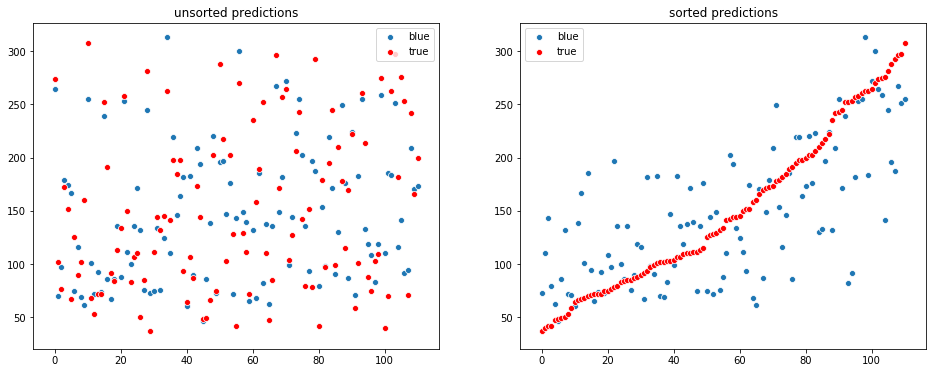

In [147]:
pred = Predictor(to_path='mlbox_save').fit_predict(best, rd_data)
y_pred = np.loadtxt('mlbox_save/y_predictions.csv', skiprows=1, delimiter=',')[:, 1]
visualize_regression(y_test, y_pred)